In [2]:
# import numpy as np
# import cudf as pd
# from cuml.preprocessing import LabelEncoder
# from cuml.linear_model import LogisticRegression, LinearRegression
# from cuml.ensemble import RandomForestClassifier
# from cuml.model_selection import train_test_split
# from cuml.cluster import KMeans
# from cuml.metrics import accuracy_score
# from cuml import UMAP, PCA, TSNE
# from cuml.metrics import confusion_matrix
# import datashader as ds
# import datashader.transfer_functions as tf
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(rc = {'figure.figsize':(10,10)})
# sns.set_style("darkgrid")

# About this Data

This is a dataset of **drugs (by NDC)**, that includes a **variable** to determine if it is a **counterfeit** drug or not.  
This is a **binary classification** problem.

# Input filename

In [5]:
in_filename = 'sample_data_500k.csv'
# out_filename = 'write_speed_test.csv'

# Define variables

In [6]:
label_col_name = 'Medwatch or 3911 drug' # the name of the column that contain the labels (0 for negative, 1 for positive)

predictor_col_names = ['Size of U.S. market', # the names of the columns that will be used to predict the label
                       'Price per unit', 
                       'RX/OTC', 
                       'Indication',
                       'Drug Class',
                       'Shortage',
                       'Twitter Mentions'
                      ] 

cetegoric_predictor_col_names = ['RX/OTC', # list of predictor columns that are not values; will use a label encoder on these
                                 'Indication',
                                 'Drug Class', 
                                 'Shortage'
                                ]

# models perform better when values are between 0 and 1. 
# thus, we use a scaling value to attempt to do this
scaling_dict = {'Size of U.S. market': 1/100000000000, # each column in this dictionary will be multiplied by the values here
                'Price per unit': 1/10000,
                'Twitter Mentions': 1/200000
               }

val_set_percent = 0.1 # percent of data to be reserved for validation
test_set_percent = 0.1 # percent of data to be reserved for testing

In [7]:
random_seed = 42 # to make results reproducible

# Load data

In [8]:
np.random.seed(seed=random_seed)

In [9]:
%%time
df = pd.read_csv(in_filename)

CPU times: user 731 ms, sys: 396 ms, total: 1.13 s
Wall time: 1.13 s


In [10]:
# %%time
# df.to_csv(out_filename, index=False)

In [11]:
df

,NDC,Medwatch or 3911 drug,Size of U.S. market,Price per unit,RX/OTC,Indication,SNOMED,Drug Class,Shortage,Twitter Mentions
0,6374-6926-74,0,1.811017e+09,1.11,RX,endocrinology,362969004,androgen,current shortage,13061.0
1,3772-5417-51,1,4.504540e+09,911.77,RX,endocrinology,362969004,corticosteroid,current shortage,17800.0
2,4095-8092-63,1,2.846883e+09,882.48,OTC,pain management,373621006,opioid agonist,current shortage,16461.0
3,8242-6486-13,1,2.847908e+09,140.77,RX,heart disease,73211009,ACE inhibitor,current shortage,11485.0
4,8198-9413-67,1,7.262335e+09,622.05,RX,chemotherapy,80659006,antimetabolite,current shortage,16741.0
...,...,...,...,...,...,...,...,...,...,...
499995,4622-4793-61,0,2.336032e+07,0.90,OTC,gastroenterology,119292006,acetylcholinergic,current shortage,4691.0
499996,8543-3178-62,0,9.637667e+09,580.37,OTC,gastroenterology,119292006,dopamine-2 receptor antagonist,no shortage,299.0
499997,1572-4266-02,0,4.942455e+06,2.19,RX,heart disease,73211009,platelet aggregation inhibitor,no shortage,8955.0
499998,8560-0675-06,0,1.766831e+07,0.30,OTC,gastroenterology,119292006,acetylcholinergic,no shortage,3658.0


# Explore Data

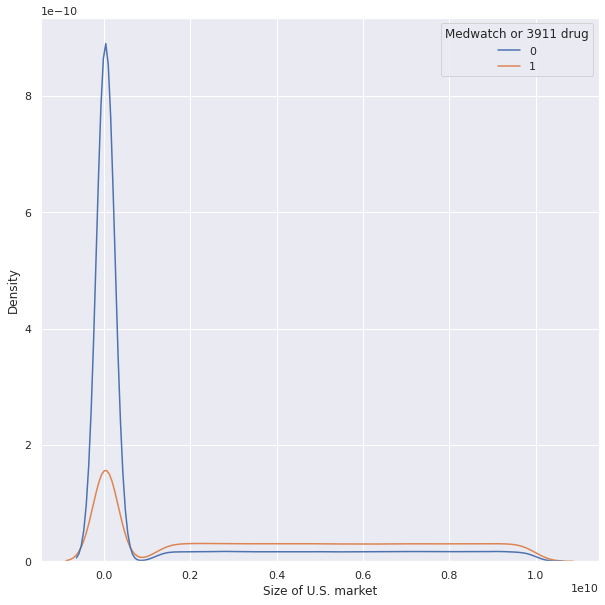

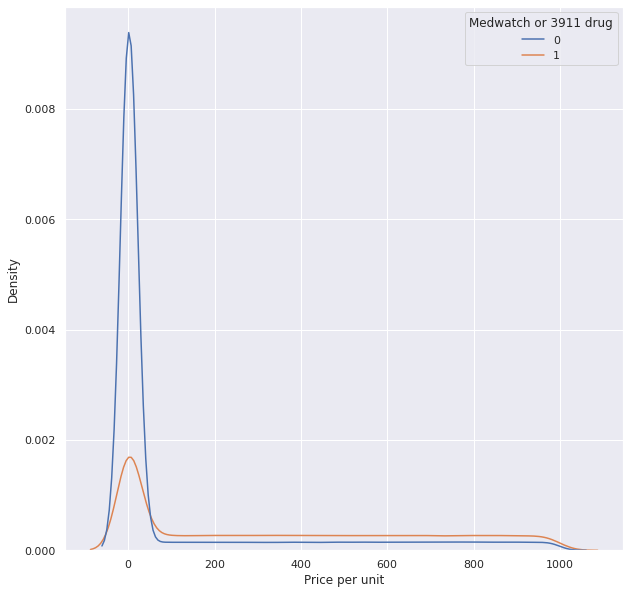

RX/OTC


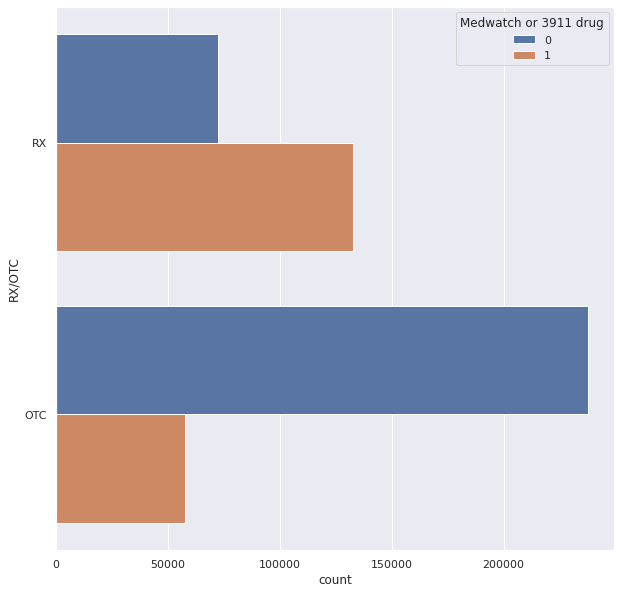

Indication


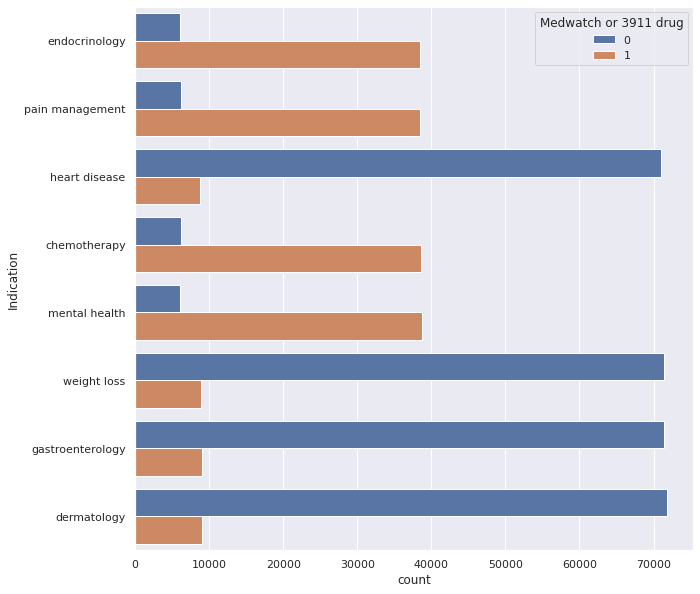

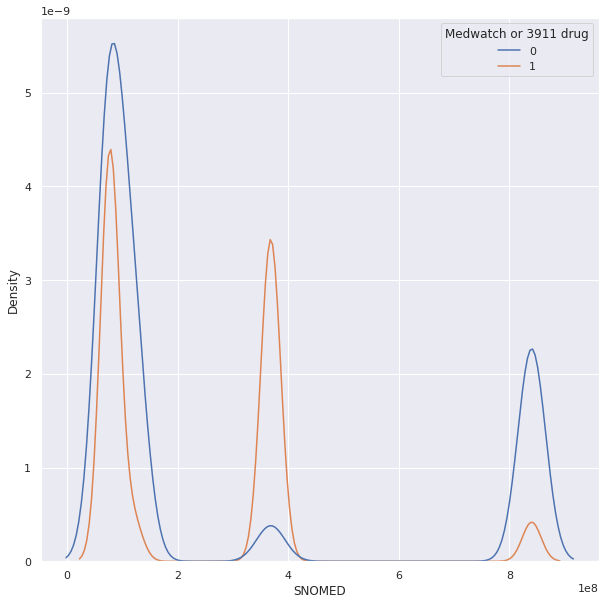

Drug Class


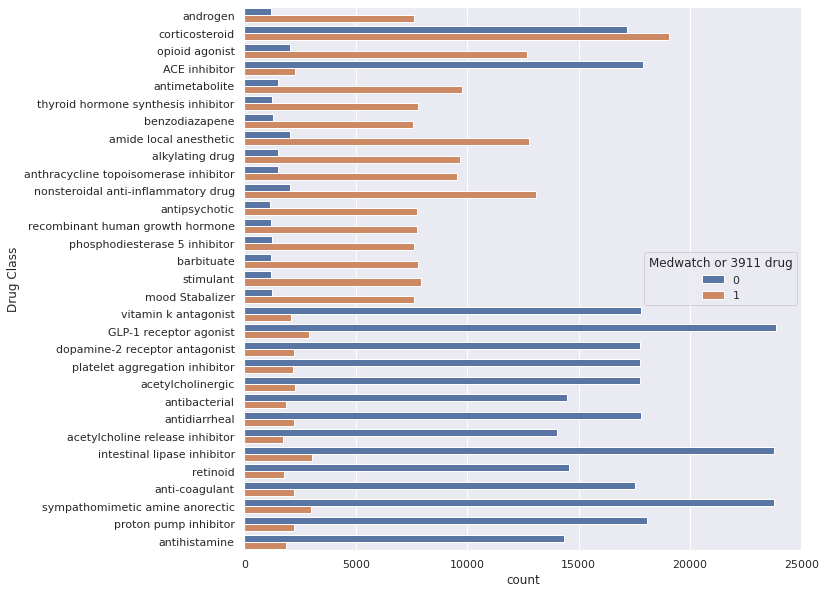

Shortage


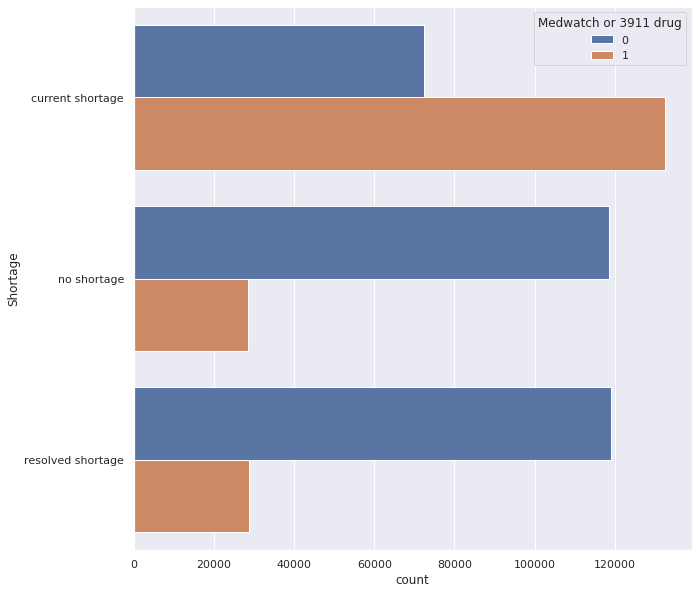

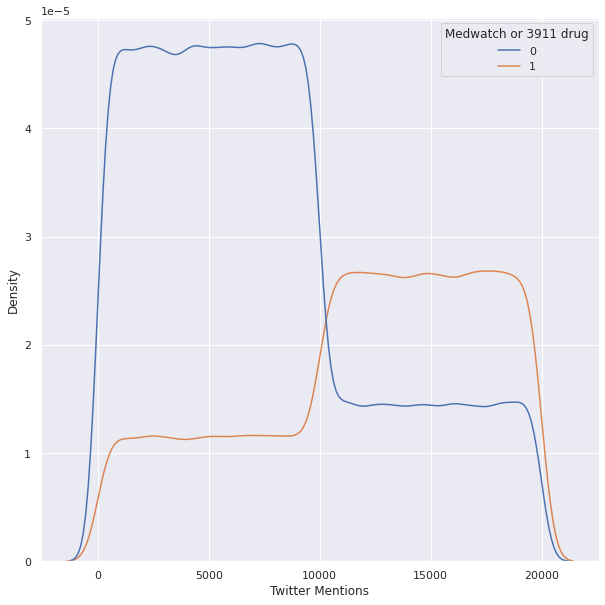

In [12]:
for cur_col in df.columns:
    if (cur_col != label_col_name) & (cur_col != 'NDC') & (df[cur_col].dtype != object):
        fig = sns.kdeplot(data=df.to_pandas(), x=cur_col, hue=label_col_name)
        plt.show()
    if (cur_col != label_col_name) & (cur_col != 'NDC') & (df[cur_col].dtype == object):
        print(cur_col)
        fig = sns.countplot(data=df.to_pandas(), y=cur_col, hue=label_col_name)
        plt.show()


# Preprocess data

In [13]:
df_input = df.copy()

### fit label encoder
first we create a label encoder for each column specified in the variable 'cetegoric_predictor_col_names' 
defined at the top of the notebook

In [14]:
%%time
le_dict = {}
for col in df_input.columns:
    if col in cetegoric_predictor_col_names:
        le_dict[col] = LabelEncoder()
        le_dict[col].fit(df_input[col].unique())

CPU times: user 7.55 ms, sys: 51.5 ms, total: 59.1 ms
Wall time: 57.7 ms


### encode categoric columns
Then we apply the label encoder to the values of those columns

In [15]:
%%time
for col in df_input.columns:
    if col in cetegoric_predictor_col_names:
        df_input[col] = le_dict[col].transform(df_input[col])

CPU times: user 31.8 ms, sys: 55.8 ms, total: 87.6 ms
Wall time: 87 ms


In [16]:
df_input

,NDC,Medwatch or 3911 drug,Size of U.S. market,Price per unit,RX/OTC,Indication,SNOMED,Drug Class,Shortage,Twitter Mentions
0,6374-6926-74,0,1.811017e+09,1.11,1,2,362969004,6,0,13061.0
1,3772-5417-51,1,4.504540e+09,911.77,1,2,362969004,16,0,17800.0
2,4095-8092-63,1,2.846883e+09,882.48,0,6,373621006,21,0,16461.0
3,8242-6486-13,1,2.847908e+09,140.77,1,4,73211009,0,0,11485.0
4,8198-9413-67,1,7.262335e+09,622.05,1,0,80659006,12,0,16741.0
...,...,...,...,...,...,...,...,...,...,...
499995,4622-4793-61,0,2.336032e+07,0.90,0,3,119292006,3,0,4691.0
499996,8543-3178-62,0,9.637667e+09,580.37,0,3,119292006,17,1,299.0
499997,1572-4266-02,0,4.942455e+06,2.19,1,4,73211009,23,1,8955.0
499998,8560-0675-06,0,1.766831e+07,0.30,0,3,119292006,3,1,3658.0


### scale value variable columns
Next we apply the scaling by the variable 'scaling_dict' defined at the top of the notebook

In [17]:
%%time
for col in scaling_dict.keys():
    df_input[col] = df_input[col] * scaling_dict[col]

CPU times: user 3.84 ms, sys: 0 ns, total: 3.84 ms
Wall time: 2.72 ms


In [18]:
df_input

,NDC,Medwatch or 3911 drug,Size of U.S. market,Price per unit,RX/OTC,Indication,SNOMED,Drug Class,Shortage,Twitter Mentions
0,6374-6926-74,0,0.018110,0.000111,1,2,362969004,6,0,0.065305
1,3772-5417-51,1,0.045045,0.091177,1,2,362969004,16,0,0.089000
2,4095-8092-63,1,0.028469,0.088248,0,6,373621006,21,0,0.082305
3,8242-6486-13,1,0.028479,0.014077,1,4,73211009,0,0,0.057425
4,8198-9413-67,1,0.072623,0.062205,1,0,80659006,12,0,0.083705
...,...,...,...,...,...,...,...,...,...,...
499995,4622-4793-61,0,0.000234,0.000090,0,3,119292006,3,0,0.023455
499996,8543-3178-62,0,0.096377,0.058037,0,3,119292006,17,1,0.001495
499997,1572-4266-02,0,0.000049,0.000219,1,4,73211009,23,1,0.044775
499998,8560-0675-06,0,0.000177,0.000030,0,3,119292006,3,1,0.018290


# Split Data

We split the dataframe into inputs (X) and outputs/targets (y)

In [19]:
X = df_input[predictor_col_names].copy()
y = df_input[label_col_name].copy()

Then we split the data into training and test sets

In [20]:
not_train_prct = val_set_percent + test_set_percent
train_prct = 1. - not_train_prct
test_prct = test_set_percent / not_train_prct
val_prct = 1. - test_prct

In [21]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=not_train_prct, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_prct, random_state=random_seed)

CPU times: user 69.5 ms, sys: 9.15 ms, total: 78.7 ms
Wall time: 77.8 ms


In [22]:
del df, df_input

In [23]:
X_train

,Size of U.S. market,Price per unit,RX/OTC,Indication,Drug Class,Shortage,Twitter Mentions
395324,0.019970,0.000192,0,4,0,2,0.013130
498962,0.000684,0.000092,1,7,1,2,0.027295
333587,0.000451,0.000250,1,3,10,1,0.030720
432664,0.088647,0.022177,0,1,16,2,0.062230
145039,0.093280,0.080871,1,5,27,0,0.093310
...,...,...,...,...,...,...,...
30480,0.052268,0.000068,1,6,20,0,0.061160
429553,0.000532,0.000033,0,7,1,2,0.045110
339216,0.000663,0.000136,0,4,30,2,0.012660
295058,0.000766,0.071250,0,7,28,2,0.021195


In [24]:
y_train

395324    0
498962    0
333587    0
432664    0
145039    1
         ..
30480     1
429553    0
339216    0
295058    0
471278    0
Name: Medwatch or 3911 drug, Length: 400000, dtype: int64

# Dimentionality Reduction and Visualization

In [25]:
%%time
umap = UMAP(random_state=random_seed)
df_umap = umap.fit_transform(X_train).rename(columns={0:'x', 1:'y'})
df_umap['cat'] = y_train
df_umap['cat'] = df_umap['cat'].astype('category')
df_umap

CPU times: user 765 ms, sys: 3.11 s, total: 3.87 s
Wall time: 3.87 s


,x,y,cat
395324,-1.458666,-0.522178,0
498962,-10.037170,-5.084780,0
333587,10.713770,-2.163948,0
432664,7.044956,4.443323,0
145039,1.489634,4.520207,1
...,...,...,...
30480,-5.723729,-1.294610,1
429553,-7.730298,-10.130998,0
339216,0.637428,-6.267126,0
295058,4.760398,-1.919184,0


CPU times: user 1.57 s, sys: 32.9 ms, total: 1.61 s
Wall time: 1.61 s


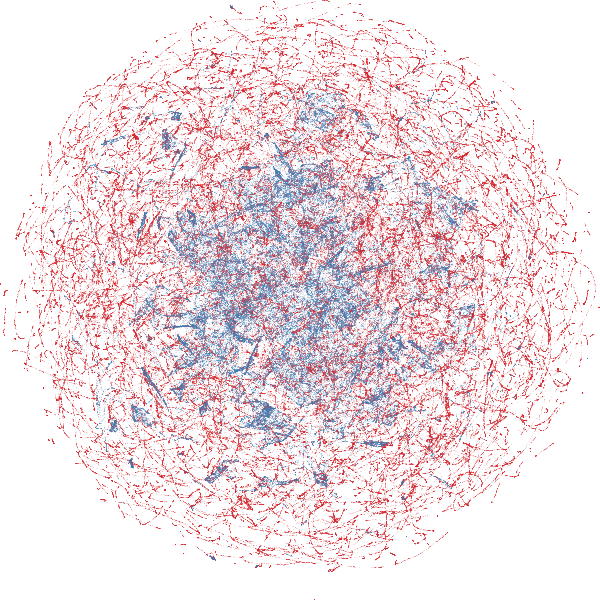

In [26]:
%%time
agg_c = ds.Canvas().points(df_umap,'x','y', ds.by('cat', ds.count()))
tf.shade(agg_c, how='eq_hist')

In [27]:
del df_umap, umap

In [28]:
# import holoviews as hv
# import holoviews.operation.datashader as hd
# import datashader as ds
# hd.shade.cmap=["lightblue", "darkblue"]
# hv.extension("bokeh")
# hv.output(backend="bokeh")

# df_umap['cat'] = df_umap['cat'].astype('str')
# points = hv.Points(df_umap)
# datashaded = hd.datashade(points, aggregator=ds.count_cat('cat'))
# hd.dynspread(datashaded, how='saturate').opts(height=800,width=800)

# Goal

Our goal is to **maximize accuracy** 

# OLS Regression

In [29]:
%%time
for a_pred_col in predictor_col_names:
    reg = LinearRegression()
    reg.fit(X_train[a_pred_col].values.reshape(-1,1).astype(float), y_train)
    col_score = accuracy_score(reg.predict(X_train[a_pred_col].values.reshape(-1,1)).round(), y_train)
    print(f'OLS Regression Score using only column \'{a_pred_col}\' was {col_score}')

OLS Regression Score using only column 'Size of U.S. market' was 0.6971799731254578
OLS Regression Score using only column 'Price per unit' was 0.6891599893569946
OLS Regression Score using only column 'RX/OTC' was 0.7401224970817566
OLS Regression Score using only column 'Indication' was 0.6200050115585327
OLS Regression Score using only column 'Drug Class' was 0.6200050115585327
OLS Regression Score using only column 'Shortage' was 0.7394275069236755
OLS Regression Score using only column 'Twitter Mentions' was 0.7076249718666077
CPU times: user 57.5 ms, sys: 33.3 ms, total: 90.8 ms
Wall time: 90.1 ms


/home/jcosme/miniconda3/envs/ds/lib/python3.9/site-packages/cuml/internals/api_decorators.py:409: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


In [30]:
%%time
reg = LinearRegression()
reg.fit(X_train, y_train)

CPU times: user 4.05 ms, sys: 16.1 ms, total: 20.1 ms
Wall time: 18.8 ms


LinearRegression()

In [31]:
ols_acc_train = accuracy_score(reg.predict(X_train).round().astype(int), y_train)
print(f'OLS Regression train set accuracy using all columns was {ols_acc_train}')

OLS Regression train set accuracy using all columns was 0.831309974193573


In [32]:
def return_cm_plot_gpu(pred, true, plot_title):
    cur_cm_train = confusion_matrix(pred, true)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cur_cm_train.get().flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cur_cm_train.get().flatten()/np.sum(cur_cm_train.get())]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    hm = sns.heatmap(cur_cm_train.get(), annot=labels, fmt='', cmap='Blues', annot_kws={"size":25})
    hm.set_xlabel("Predicted", fontsize = 15)
    hm.set_ylabel("Actual", fontsize = 15)
    hm.set_title(plot_title, size=20)
    
    return hm

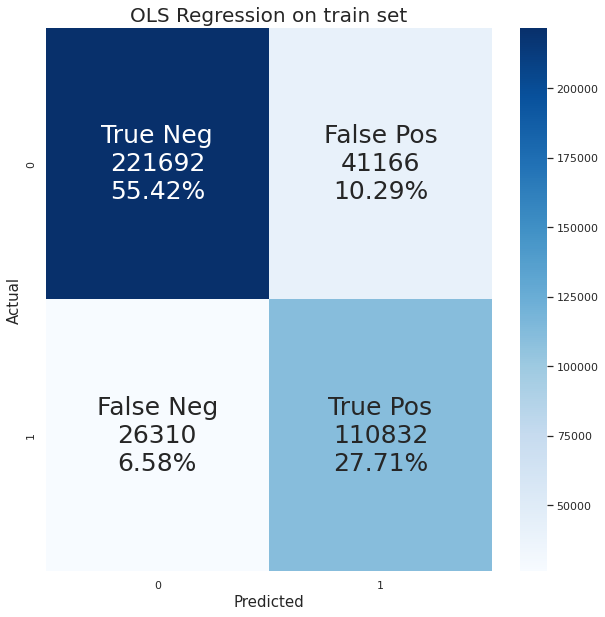

In [28]:
hm = return_cm_plot_gpu(reg.predict(X_train).round().astype(int), y_train, "OLS Regression on train set")


In [33]:
del reg

# Logistic Regression


In [34]:
%%time
logit_reg = LogisticRegression(penalty='none')#, class_weight=class_weight)
logit_reg.fit(X_train, y_train)

CPU times: user 84.9 ms, sys: 189 ms, total: 274 ms
Wall time: 274 ms


LogisticRegression()

In [35]:
logit_acc_train = accuracy_score(logit_reg.predict(X_train).round().astype(int), y_train)
print(f'Logistic Regression train set accuracy was {logit_acc_train}')

Logistic Regression train set accuracy was 0.831695020198822


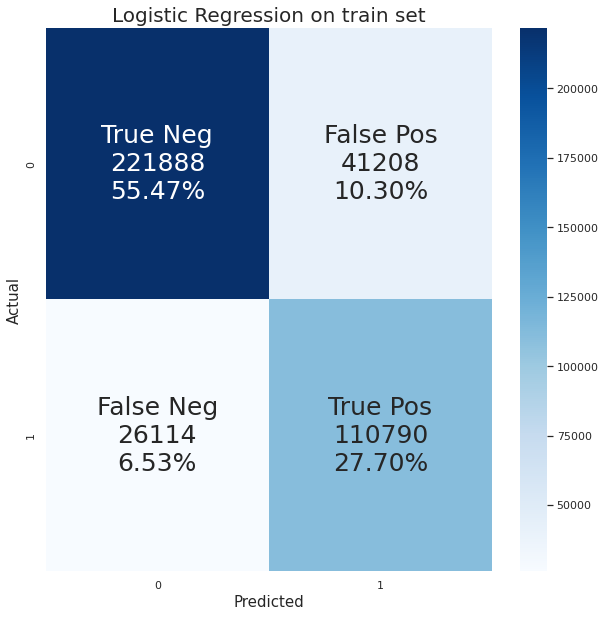

In [36]:
hm = return_cm_plot_gpu(logit_reg.predict(X_train).round().astype(int), y_train, "Logistic Regression on train set")

In [37]:
del logit_reg

# K-Means

We now perform the same analysis using K-Means clustering

In [38]:
%%time
kmeans = KMeans(n_clusters=len(y_train.unique()), random_state=random_seed)
kmeans.fit(X_train)

CPU times: user 16.5 ms, sys: 80.5 ms, total: 97.1 ms
Wall time: 96.7 ms


KMeans()

In [39]:
kmeans_acc_train = accuracy_score(kmeans.predict(X_train).round().astype(int), y_train)
print(f'K-Means train set accuracy was {kmeans_acc_train}')

K-Means train set accuracy was 0.5108349919319153


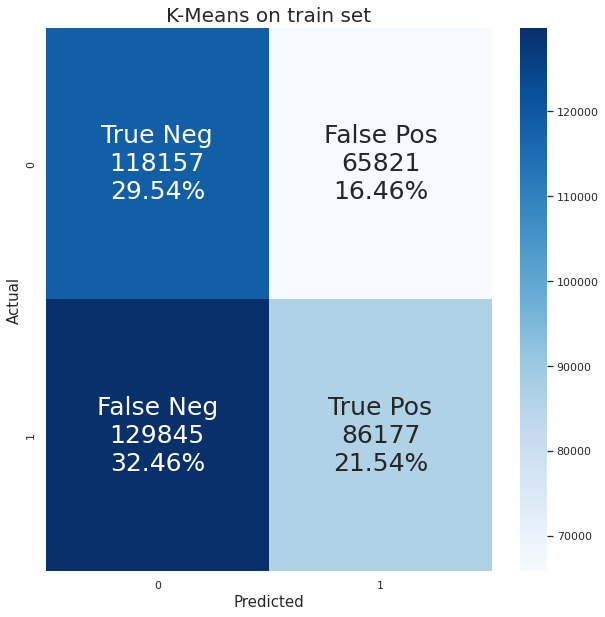

In [40]:
hm = return_cm_plot_gpu(kmeans.predict(X_train).round().astype(int), y_train, "K-Means on train set")

In [41]:
del kmeans

# Random Forest Regression

In [42]:
%%time
rando_forest = RandomForestClassifier(max_depth=1, random_state=random_seed, n_streams=16)
rando_forest.fit(X_train.astype(np.float32), y_train.astype(np.float32))

/home/jcosme/miniconda3/envs/ds/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


CPU times: user 479 ms, sys: 473 ms, total: 953 ms
Wall time: 423 ms


RandomForestClassifier()

In [43]:
randfrst_acc_train = accuracy_score(rando_forest.predict(X_train), y_train)
print(f'Random Forest train set accuracy was {randfrst_acc_train}')

Random Forest train set accuracy was 0.8274350166320801


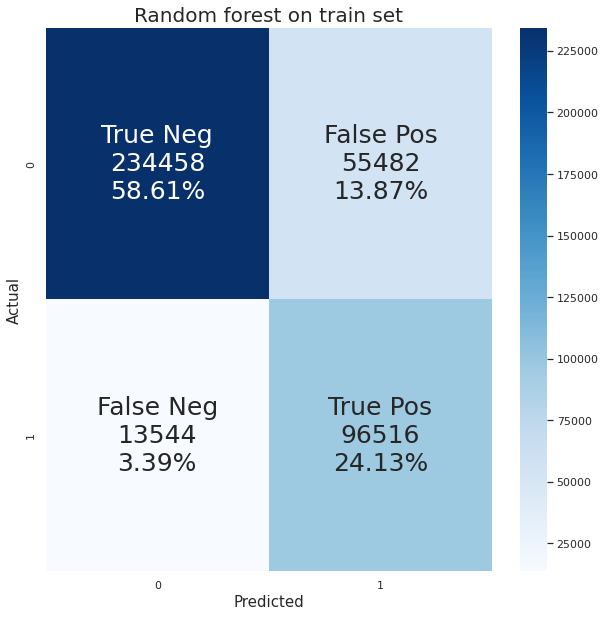

In [44]:
hm = return_cm_plot_gpu(rando_forest.predict(X_train).astype(int), y_train, "Random forest on train set")

In [41]:
del rando_forest

# Gradient Boosting

In [45]:
%%time
from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, random_state=random_seed)
xgb.fit(X_train, y_train)

[04:38:12] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1649372530131/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 249 ms, sys: 217 ms, total: 466 ms
Wall time: 468 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [46]:
gb_acc_train = accuracy_score(xgb.predict(X_train), y_train)
print(f'Gradient Boosting train set accuracy was {gb_acc_train}')

Gradient Boosting train set accuracy was 0.8896725177764893


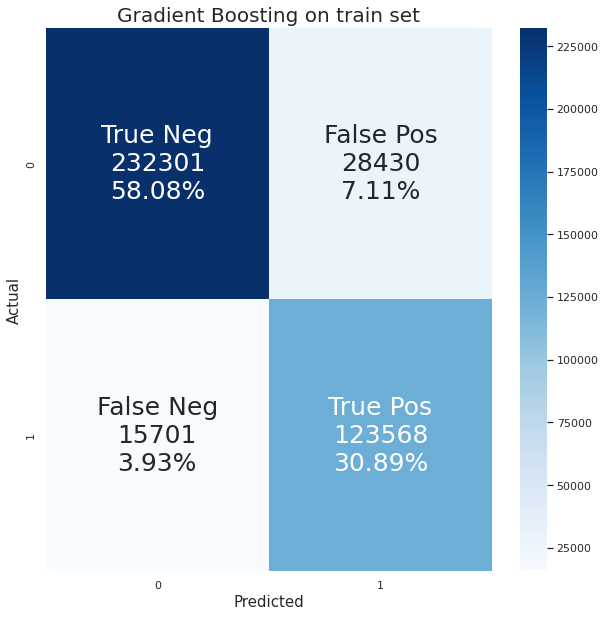

In [47]:
hm = return_cm_plot_gpu(xgb.predict(X_train), y_train, "Gradient Boosting on train set")

In [48]:
del xgb

# Hyperparameter Tuning

In [46]:
%%time
max_depth_grid_search_vals = np.arange(1,9)
val_acc_scores = []
for cur_max_depth in max_depth_grid_search_vals:
    xgb = XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, random_state=random_seed, max_depth=cur_max_depth)
    xgb.fit(X_train, y_train)
    gb_acc_val = accuracy_score(xgb.predict(X_val), y_val)
    val_acc_scores.append(gb_acc_val)
    print(f"\ncurrent max depth is: {cur_max_depth}")
    print(f'Gradient Boosting val set accuracy was {gb_acc_val}\n')

[03:42:08] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1649372530131/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

current max depth is: 1
Gradient Boosting val set accuracy was 0.8901200294494629

[03:42:08] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1649372530131/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

current max depth is: 2
Gradient Boosting val set accuracy was 0.8837400078773499

[03:42:08] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1649372530131/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed fr

In [47]:
del xgb

# Final Model & Testing

In [48]:
best_max_depth = max_depth_grid_search_vals[np.argmax(val_acc_scores)]
print(f"best accuracy score on val set was {max(val_acc_scores)}\ncorresponding to a max depth of {best_max_depth}")

best accuracy score on val set was 0.8906599879264832
corresponding to a max depth of 7


In [49]:
%%time
xgb = XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, max_depth=best_max_depth)
xgb.fit(X_train, y_train)

[03:42:10] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1649372530131/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 294 ms, sys: 257 ms, total: 551 ms
Wall time: 548 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

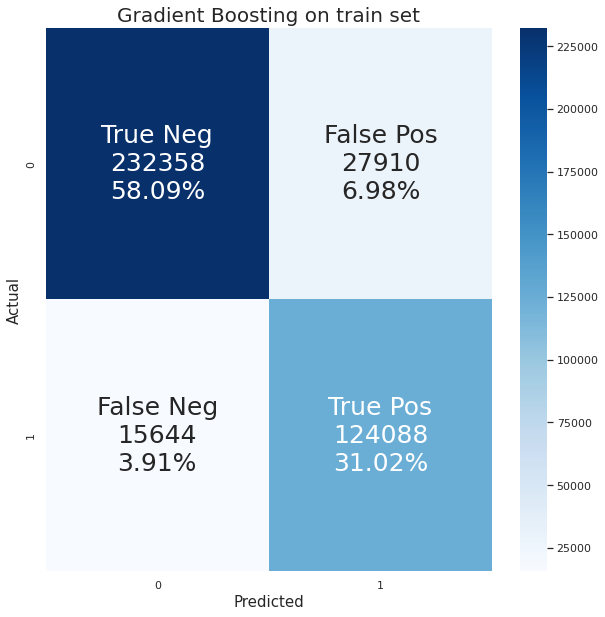

In [50]:
hm = return_cm_plot_gpu(xgb.predict(X_train), y_train, "Gradient Boosting on train set")

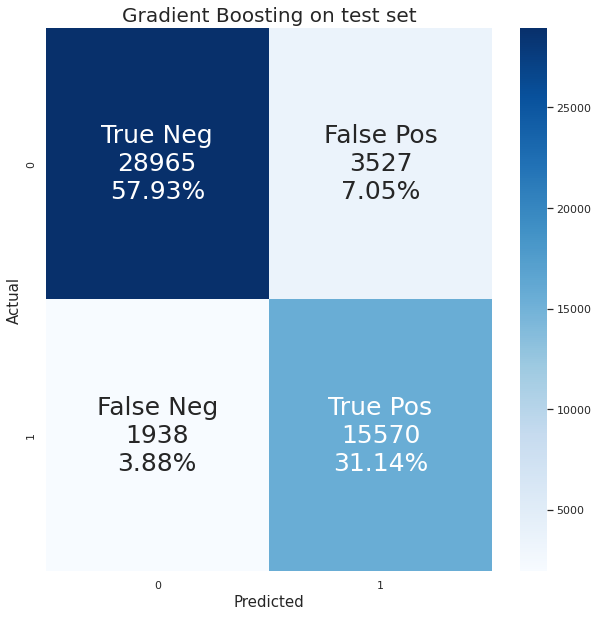

In [51]:
hm = return_cm_plot_gpu(xgb.predict(X_test), y_test, "Gradient Boosting on test set")

In [52]:
%time
xgb.save_model('final_model.json')

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 5.96 µs


/home/jcosme/miniconda3/envs/ds/lib/python3.9/site-packages/xgboost/sklearn.py:585: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


In [53]:
del xgb